In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import sklearn.metrics as metrics
from sklearn.preprocessing import MinMaxScaler

In [2]:
# params
learning_rate = 0.01
n_epochs = 1000
train_test_split_ratio = 0.8
split_date = "2022-01-01"
lookback = 60
batch_size = 16

ticker = "GOOG"
start = "2017-01-01"
end = "2022-12-31"

feature_columns = [
    f"close_{ticker}",
    f"volume_{ticker}",
    "macd",
    "rsi",
    "atr",
    "close_vix",
    "close_usd",
    "EFFR",
    "UNRATE",
    "UMCSENT"
]

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [4]:
device

'cuda'

In [5]:
data_df = pd.read_csv(f"../data/data_{ticker}_{start}_{end}.csv", index_col=0)

In [6]:
data_df

EFFR  UNRATE  UMCSENT  open_GOOG  high_GOOG   low_GOOG  \
Date                                                                 
2017-01-04  0.66     4.7     98.5  39.417999  39.567001  39.158001   
2017-01-05  0.66     4.7     98.5  39.304001  39.723999  39.250999   
2017-01-06  0.66     4.7     98.5  39.763000  40.395000  39.610199   
2017-01-09  0.66     4.7     98.5  40.320000  40.498299  40.141499   
2017-01-10  0.66     4.7     98.5  40.393002  40.456501  40.175499   
...          ...     ...      ...        ...        ...        ...   
2022-12-23  4.33     3.5     59.7  87.620003  90.099998  87.620003   
2022-12-27  4.33     3.5     59.7  89.309998  89.500000  87.535004   
2022-12-28  4.33     3.5     59.7  87.500000  88.519997  86.370003   
2022-12-29  4.33     3.5     59.7  87.029999  89.364998  86.989998   
2022-12-30  4.33     3.5     59.7  87.364998  88.830002  87.029999   

            close_GOOG  volume_GOOG  dividends_GOOG  stock splits_GOOG  ...  \
Date                                                                    ...   
2017-01-04   39.345001   21460000.0             0.0                0.0  ...   
2017-01-05   39.701000   26704000.0             0.0                0.0  ...   
2017-01-06   40.307499   32804000.0             0.0                0.0  ...   
2017-01-09   40.332500   25492000.0             0.0                0.0  ...   
2017-01-10   40.239498   23536000.0             0.0                0.0  ...   
...                ...          ...             ...                ...  ...   
2022-12-23   89.809998   17815000.0             0.0                0.0  ...   
2022-12-27   87.930000   15470900.0             0.0                0.0  ...   
2022-12-28   86.459999   17879600.0             0.0                0.0  ...   
2022-12-29   88.949997   18280700.0             0.0                0.0  ...   
2022-12-30   88.730003   19190300.0             0.0                0.0  ...   

            volume_vix  dividends_vix  stock splits_vix    open_usd  \
Date                                                                  
2017-01-04         0.0            0.0               0.0  103.180000   
2017-01-05         0.0            0.0               0.0  102.430000   
2017-01-06         0.0            0.0               0.0  101.419998   
2017-01-09         0.0            0.0               0.0  102.260002   
2017-01-10         0.0            0.0               0.0  101.849998   
...                ...            ...               ...         ...   
2022-12-23         0.0            0.0               0.0  104.389999   
2022-12-27         0.0            0.0               0.0  104.120003   
2022-12-28         0.0            0.0               0.0  104.330002   
2022-12-29         0.0            0.0               0.0  104.370003   
2022-12-30         0.0            0.0               0.0  103.949997   

              high_usd     low_usd   close_usd  volume_usd  dividends_usd  \
Date                                                                        
2017-01-04  103.440002  102.389999  102.699997         0.0            0.0   
2017-01-05  102.510002  101.300003  101.519997         0.0            0.0   
2017-01-06  102.290001  101.370003  102.220001         0.0            0.0   
2017-01-09  102.519997  101.800003  101.930000         0.0            0.0   
2017-01-10  102.099998  101.510002  102.010002         0.0            0.0   
...                ...         ...         ...         ...            ...   
2022-12-23  104.540001  104.120003  104.309998         0.0            0.0   
2022-12-27  104.400002  103.889999  104.180000         0.0            0.0   
2022-12-28  104.559998  103.849998  104.459999         0.0            0.0   
2022-12-29  104.449997  103.779999  103.839996         0.0            0.0   
2022-12-30  104.099998  103.389999  103.519997         0.0            0.0   

            stock splits_usd  
Date                          
2017-01-04               0.0  
2017-01-05               0.0  
2017-01-06             

In [7]:
data_df.index = pd.to_datetime(data_df.index)

In [8]:
features_df = data_df[feature_columns]

In [9]:
features_df.loc[:,f"next_close_{ticker}"] = features_df[f"close_{ticker}"].shift(-1)

C:\Users\gabes\AppData\Local\Temp\ipykernel_9884\2357976536.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features_df.loc[:,f"next_close_{ticker}"] = features_df[f"close_{ticker}"].shift(-1)


In [10]:
features_df.loc[:,"label"] = features_df[f"next_close_{ticker}"] - features_df[f"close_{ticker}"] >= 0

C:\Users\gabes\AppData\Local\Temp\ipykernel_9884\554408274.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features_df.loc[:,"label"] = features_df[f"next_close_{ticker}"] - features_df[f"close_{ticker}"] >= 0


In [11]:
features_df.loc[:,"label"] = features_df["label"].apply(int)

C:\Users\gabes\AppData\Local\Temp\ipykernel_9884\670736284.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features_df.loc[:,"label"] = features_df["label"].apply(int)


In [12]:
features_df

close_GOOG  volume_GOOG      macd         rsi       atr  \
Date                                                                  
2017-01-04   39.345001   21460000.0  0.000853  100.000000  0.545018   
2017-01-05   39.701000   26704000.0  0.012126  100.000000  0.519212   
2017-01-06   40.307499   32804000.0  0.038853  100.000000  0.593162   
2017-01-09   40.332500   25492000.0  0.053554  100.000000  0.538637   
2017-01-10   40.239498   23536000.0  0.057407   90.235509  0.487370   
...                ...          ...       ...         ...       ...   
2022-12-23   89.809998   17815000.0 -1.985857   40.448557  2.842450   
2022-12-27   87.930000   15470900.0 -2.135107   37.053470  2.801918   
2022-12-28   86.459999   17879600.0 -2.344974   34.607436  2.755352   
2022-12-29   88.949997   18280700.0 -2.284044   41.635682  2.766041   
2022-12-30   88.730003   19190300.0 -2.227827   41.214217  2.705609   

            close_vix   close_usd  EFFR  UNRATE  UMCSENT  next_close_GOOG  \
Date                                                                        
2017-01-04  11.850000  102.699997  0.66     4.7     98.5        39.701000   
2017-01-05  11.670000  101.519997  0.66     4.7     98.5        40.307499   
2017-01-06  11.320000  102.220001  0.66     4.7     98.5        40.332500   
2017-01-09  11.560000  101.930000  0.66     4.7     98.5        40.239498   
2017-01-10  11.490000  102.010002  0.66     4.7     98.5        40.395500   
...               ...         ...   ...     ...      ...              ...   
2022-12-23  20.870001  104.309998  4.33     3.5     59.7        87.930000   
2022-12-27  21.650000  104.180000  4.33     3.5     59.7        86.459999   
2022-12-28  22.139999  104.459999  4.33     3.5     59.7        88.949997   
2022-12-29  21.440001  103.839996  4.33     3.5     59.7        88.730003   
2022-12-30  21.670000  103.519997  4.33     3.5     59.7              NaN   

            label  
Date               
2017-01-04      1  
2017-01-05      1  
2017-01-06      1  
2017-01-09      0  
2017-01-10      1  
...           ...  
2022-12-23      0  
2022-12-27      0  
2022-12-28      1  
2022-12-29      0  
2022-12-30      0  

[1509 rows x 12 columns]

In [12]:
features_df = features_df.iloc[1:,:]

In [13]:
features_df.reset_index(inplace=True)

In [14]:
features_df["label"].sum()

815

In [15]:
# train-test split for time series
date_change_index =  features_df.loc[features_df["Date"] >= split_date,:].index[0]

train_df = features_df.iloc[:date_change_index,:]
test_df = features_df.iloc[date_change_index - lookback:,:]

scaler = MinMaxScaler()
scaler.fit(train_df[feature_columns])

MinMaxScaler()

In [16]:
train_df

Date  close_GOOG  volume_GOOG      macd         rsi       atr  \
0    2017-01-05   39.701000   26704000.0  0.012126  100.000000  0.519212   
1    2017-01-06   40.307499   32804000.0  0.038853  100.000000  0.593162   
2    2017-01-09   40.332500   25492000.0  0.053554  100.000000  0.538637   
3    2017-01-10   40.239498   23536000.0  0.057407   90.235509  0.487370   
4    2017-01-11   40.395500   21318000.0  0.065957   91.699605  0.461185   
...         ...         ...          ...       ...         ...       ...   
1252 2021-12-27  148.063995   13256000.0  0.160581   55.472989  2.996184   
1253 2021-12-28  146.447998   18624000.0  0.185665   51.446599  2.956385   
1254 2021-12-29  146.504501   17022000.0  0.207709   51.578937  2.865161   
1255 2021-12-30  146.002502   12978000.0  0.182567   50.268029  2.753649   
1256 2021-12-31  144.679504   17298000.0  0.055251   46.885950  2.677496   

      close_vix   close_usd  EFFR  UNRATE  UMCSENT  next_close_GOOG  label  
0     11.670000  101.519997  0.66     4.7     98.5        40.307499      1  
1     11.320000  102.220001  0.66     4.7     98.5        40.332500      1  
2     11.560000  101.930000  0.66     4.7     98.5        40.239498      0  
3     11.490000  102.010002  0.66     4.7     98.5        40.395500      1  
4     11.260000  101.779999  0.66     4.7     98.5        40.318001      0  
...         ...         ...   ...     ...      ...              ...    ...  
1252  17.680000   96.089996  0.08     3.9     70.6       146.447998      0  
1253  17.540001   96.199997  0.08     3.9     70.6       146.504501      1  
1254  16.950001   95.930000  0.08     3.9     70.6       146.002502      0  
1255  17.330000   95.970001  0.08     3.9     70.6       144.679504      0  
1256  17.219999   95.669998  0.07     3.9     70.6       145.074493      1  

[1257 rows x 13 columns]

In [17]:
test_df.loc[:date_change_index,:]

Date  close_GOOG  volume_GOOG      macd        rsi       atr  \
1197 2021-10-07  139.185501   18250000.0 -1.244520  50.163247  2.868842   
1198 2021-10-08  140.056000   18924000.0 -0.976193  52.065820  2.744746   
1199 2021-10-11  138.847504   16584000.0 -0.851244  49.254568  2.688490   
1200 2021-10-12  136.712997   22536000.0 -0.913923  44.667113  2.742527   
1201 2021-10-13  137.899994   16380000.0 -0.857926  47.590409  2.677847   
...         ...         ...          ...       ...        ...       ...   
1253 2021-12-28  146.447998   18624000.0  0.185665  51.446599  2.956385   
1254 2021-12-29  146.504501   17022000.0  0.207709  51.578937  2.865161   
1255 2021-12-30  146.002502   12978000.0  0.182567  50.268029  2.753649   
1256 2021-12-31  144.679504   17298000.0  0.055251  46.885950  2.677496   
1257 2022-01-03  145.074493   25214000.0 -0.013619  48.010599  2.632496   

      close_vix  close_usd  EFFR  UNRATE  UMCSENT  next_close_GOOG  label  
1197  19.540001  94.220001  0.08     4.5     71.7       140.056000      1  
1198  18.770000  94.070000  0.08     4.5     71.7       138.847504      0  
1199  20.000000  94.320000  0.08     4.5     71.7       136.712997      0  
1200  19.850000  94.519997  0.08     4.5     71.7       137.899994      1  
1201  18.639999  94.080002  0.08     4.5     71.7       141.412003      1  
...         ...        ...   ...     ...      ...              ...    ...  
1253  17.540001  96.199997  0.08     3.9     70.6       146.504501      1  
1254  16.950001  95.930000  0.08     3.9     70.6       146.002502      0  
1255  17.330000  95.970001  0.08     3.9     70.6       144.679504      0  
1256  17.219999  95.669998  0.07     3.9     70.6       145.074493      1  
1257  16.600000  96.239998  0.08     4.0     67.2       144.416504      0  

[61 rows x 13 columns]

In [18]:
train_df

Date  close_GOOG  volume_GOOG      macd         rsi       atr  \
0    2017-01-05   39.701000   26704000.0  0.012126  100.000000  0.519212   
1    2017-01-06   40.307499   32804000.0  0.038853  100.000000  0.593162   
2    2017-01-09   40.332500   25492000.0  0.053554  100.000000  0.538637   
3    2017-01-10   40.239498   23536000.0  0.057407   90.235509  0.487370   
4    2017-01-11   40.395500   21318000.0  0.065957   91.699605  0.461185   
...         ...         ...          ...       ...         ...       ...   
1252 2021-12-27  148.063995   13256000.0  0.160581   55.472989  2.996184   
1253 2021-12-28  146.447998   18624000.0  0.185665   51.446599  2.956385   
1254 2021-12-29  146.504501   17022000.0  0.207709   51.578937  2.865161   
1255 2021-12-30  146.002502   12978000.0  0.182567   50.268029  2.753649   
1256 2021-12-31  144.679504   17298000.0  0.055251   46.885950  2.677496   

      close_vix   close_usd  EFFR  UNRATE  UMCSENT  next_close_GOOG  label  
0     11.670000  101.519997  0.66     4.7     98.5        40.307499      1  
1     11.320000  102.220001  0.66     4.7     98.5        40.332500      1  
2     11.560000  101.930000  0.66     4.7     98.5        40.239498      0  
3     11.490000  102.010002  0.66     4.7     98.5        40.395500      1  
4     11.260000  101.779999  0.66     4.7     98.5        40.318001      0  
...         ...         ...   ...     ...      ...              ...    ...  
1252  17.680000   96.089996  0.08     3.9     70.6       146.447998      0  
1253  17.540001   96.199997  0.08     3.9     70.6       146.504501      1  
1254  16.950001   95.930000  0.08     3.9     70.6       146.002502      0  
1255  17.330000   95.970001  0.08     3.9     70.6       144.679504      0  
1256  17.219999   95.669998  0.07     3.9     70.6       145.074493      1  

[1257 rows x 13 columns]

In [19]:
class lstmDataset(data.Dataset):
    def __init__(self, dataframe, target, features, sequence_length=5):
        self.features = features
        self.target = target
        self.sequence_length = sequence_length
        self.y = torch.tensor(dataframe[target].values).float()
        self.X = torch.tensor(scaler.transform(dataframe[features])).float()
        self.df = dataframe

    def __len__(self):
        return self.X.shape[0] - self.sequence_length

    def __getitem__(self, i): 
        x = self.X[i:i + self.sequence_length,:]
        if x.shape[0] < lookback:
            raise IndexError("out of bounds")
        return x, torch.tensor([[i] for i in self.y[i:i + self.sequence_length]])

In [20]:
train_dataset = lstmDataset(train_df, "label", feature_columns, lookback)
test_dataset = lstmDataset(test_df, "label", feature_columns, lookback)

In [64]:
class lstmModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(input_size=len(feature_columns), hidden_size = 150, num_layers=1,batch_first=True)
        self.linear = nn.Linear(150, 30)
        self.relu = nn.ReLU()
        self.linear2 = nn.Linear(30, 1)
    
    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.relu(self.linear(x))
        x = torch.sigmoid(self.linear2(x))
        return x

In [65]:
model = lstmModel()

In [66]:
model.to(device)

lstmModel(
  (lstm): LSTM(10, 150, batch_first=True)
  (linear): Linear(in_features=150, out_features=30, bias=True)
  (relu): ReLU()
  (linear2): Linear(in_features=30, out_features=1, bias=True)
)

In [67]:
optimizer=optim.SGD(model.parameters(), lr=learning_rate)
loss_fn = nn.BCELoss()
loader = data.DataLoader(train_dataset, shuffle=True, batch_size=batch_size)

In [68]:
model.cuda()

lstmModel(
  (lstm): LSTM(10, 150, batch_first=True)
  (linear): Linear(in_features=150, out_features=30, bias=True)
  (relu): ReLU()
  (linear2): Linear(in_features=30, out_features=1, bias=True)
)

In [69]:
model.train()
for epoch in range(n_epochs):
    for X_batch, y_batch in loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        y_pred = model(X_batch)
        loss = loss_fn(y_pred, y_batch)
        
        optimizer.zero_grad()
        
        loss.backward()
        optimizer.step()
        
    if epoch % 100 == 0:
        print("Epoch: %d, loss: %1.5f" % (epoch, loss.item())) 

Epoch: 0, loss: 0.70057
Epoch: 100, loss: 0.68171
Epoch: 200, loss: 0.68628
Epoch: 300, loss: 0.69183
Epoch: 400, loss: 0.68883
Epoch: 500, loss: 0.68425
Epoch: 600, loss: 0.68874
Epoch: 700, loss: 0.68244
Epoch: 800, loss: 0.67548
Epoch: 900, loss: 0.68316


In [70]:
loss.item()

0.681431233882904

In [71]:
torch.save(model.state_dict(),  f"LSTM2_{ticker}_epochs{n_epochs}_lookback{lookback}_lr{learning_rate}_batch{batch_size}_.pth")

In [29]:
model.load_state_dict(torch.load(f"LSTM_{ticker}_epochs{n_epochs}_lookback{lookback}_lr{learning_rate}_batch{batch_size}_.pth"))

<All keys matched successfully>

In [72]:
model.eval()

lstmModel(
  (lstm): LSTM(10, 150, batch_first=True)
  (linear): Linear(in_features=150, out_features=30, bias=True)
  (relu): ReLU()
  (linear2): Linear(in_features=30, out_features=1, bias=True)
)

In [73]:
test_dataset[0][0]

tensor([[0.8962, 0.0965, 0.3819, 0.3426, 0.7925, 0.1414, 0.3956, 0.0166, 0.0893,
         0.1265],
        [0.9040, 0.1023, 0.4119, 0.3677, 0.7534, 0.1309, 0.3851, 0.0166, 0.0893,
         0.1265],
        [0.8931, 0.0823, 0.4258, 0.3306, 0.7356, 0.1477, 0.4027, 0.0166, 0.0893,
         0.1265],
        [0.8739, 0.1331, 0.4188, 0.2701, 0.7527, 0.1456, 0.4167, 0.0166, 0.0893,
         0.1265],
        [0.8846, 0.0806, 0.4251, 0.3087, 0.7323, 0.1292, 0.3858, 0.0166, 0.0893,
         0.1265],
        [0.9162, 0.1236, 0.4624, 0.4083, 0.7564, 0.1050, 0.3774, 0.0166, 0.0893,
         0.1265],
        [0.9186, 0.1221, 0.4946, 0.4151, 0.7200, 0.0973, 0.3760, 0.0166, 0.0893,
         0.1265],
        [0.9302, 0.0821, 0.5316, 0.4484, 0.7007, 0.0975, 0.3767, 0.0166, 0.0893,
         0.1265],
        [0.9380, 0.0715, 0.5682, 0.4702, 0.6685, 0.0892, 0.3654, 0.0166, 0.0893,
         0.1265],
        [0.9253, 0.0939, 0.5838, 0.4189, 0.6653, 0.0863, 0.3493, 0.0166, 0.0893,
         0.1265],
        [0

In [76]:
model(test_dataset[0][0].to("cuda"))[-1]

tensor([0.1024], device='cuda:0', grad_fn=<SelectBackward0>)

In [74]:
with torch.no_grad():
    pred = []
    # shift test predictions for plotting
    for i, (x, y) in enumerate(test_dataset):
        x, y = x.to(device), y.to(device)
        y_pred = model(x)
        pred.append(y_pred[-1])

In [75]:
p = [float(i[0]) for i in pred[:-2]]

In [76]:
len(p)

250

In [77]:
test_df.shape[0] - lookback

251

In [78]:
a = test_df.loc[date_change_index:,"label"].tolist()
a.pop();

In [79]:
len(a)

250

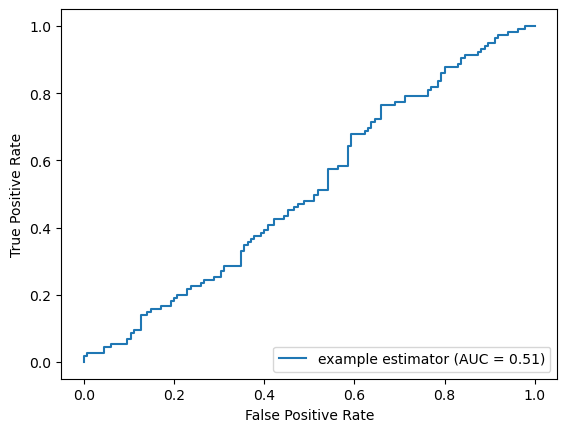

In [80]:
fpr, tpr, thresholds = metrics.roc_curve(a, p)
roc_auc = metrics.auc(fpr, tpr)
display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,
                                   estimator_name='example estimator')
display.plot() 

In [81]:
convert = [int(i > 0.5) for i in p]

In [82]:
metrics.f1_score(a, np.array([1] * len(a)))

0.6301369863013699

In [92]:
metrics.f1_score(a, convert, average="binary")

0.496

In [89]:
metrics.accuracy_score(a, convert)

0.496

(array([43., 21., 28., 10., 34., 35., 35.,  9., 12., 23.]),
 array([0.39430261, 0.41811649, 0.44193037, 0.46574425, 0.48955812,
        0.513372  , 0.53718588, 0.56099976, 0.58481364, 0.60862752,
        0.6324414 ]),
 <BarContainer object of 10 artists>)

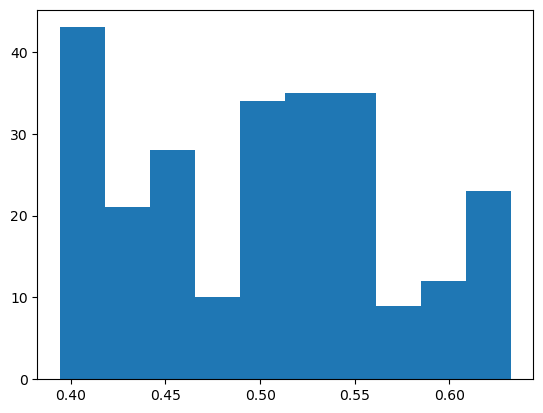

In [95]:
plt.hist(p)

In [37]:
sum(test_plot)/len(test_plot)

0.5341345416465524

In [22]:
with torch.no_grad():
    y_pred = model(X_train)
    y_pred = y_pred.cpu()
    y_pred = y_pred[:, -1, :]
    data = model(X_train)
    data = data.cpu()
    train_plot = data[:, -1, :]
    train_plot = list(i[0] for i in train_plot.numpy())
    train_plot = ([np.nan] * lookback) + train_plot

    # shift test predictions for plotting
    data = model(X_test)
    data = data.cpu()
    test_plot = data[:, -1, :]
    test_plot = list(i[0] for i in test_plot.numpy())
    test_plot = ([np.nan] * (train_size+lookback)) + test_plot
    

tseries = [i[0] for i in timeseries]
train_plot_unscaled = [i*(maximum - minimum) + minimum for i in train_plot]
test_plot_unscaled = [i*(maximum - minimum) + minimum for i in test_plot]

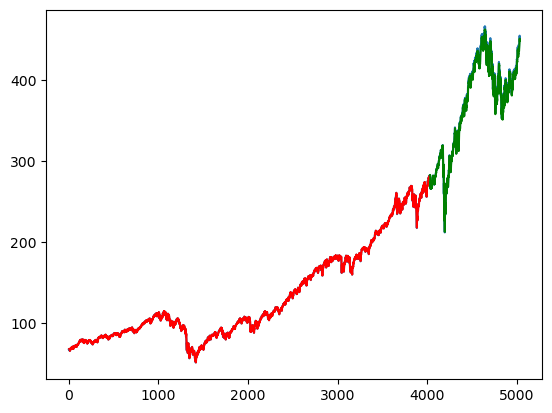

In [23]:
# # plot
plt.plot(timeseries)
plt.plot(train_plot_unscaled, c='r')
plt.plot(test_plot_unscaled, c='g')
plt.show()

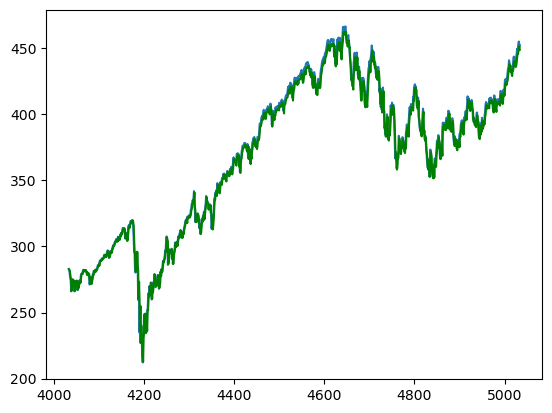

In [88]:
# # plot
plt.plot(([np.nan] * (train_size+lookback)) + tseries[lookback + train_size:])
plt.plot(test_plot_unscaled, c='g')
plt.show()

In [69]:
diff_train = [(i - j) if i != np.nan else 0 for i, j in  zip(train_plot_unscaled, tseries)]

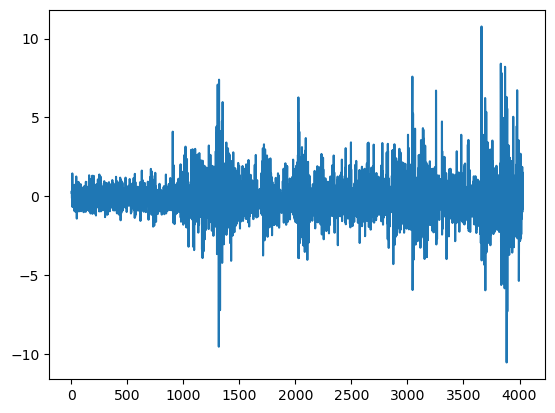

In [70]:
plt.plot(diff_train)

In [71]:
diff_test = [(i - j) if i != np.nan else 0 for i, j in  zip(test_plot_unscaled, tseries)]

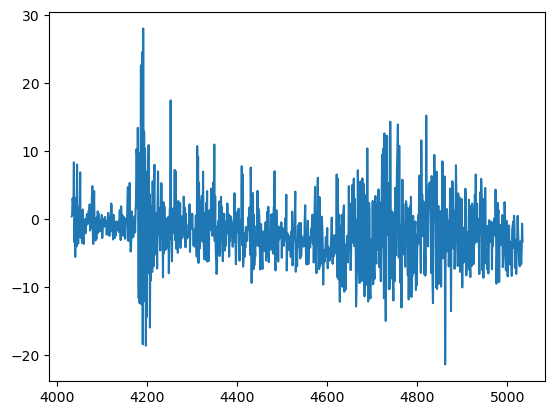

In [72]:
plt.plot(diff_test)

In [80]:
sq_diff_test = [i**2 for i in diff_test][train_size + lookback:]

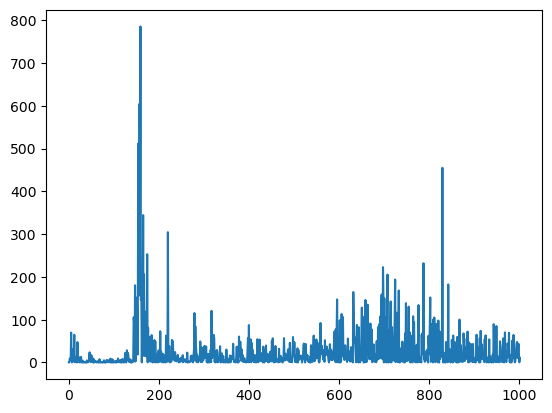

In [101]:
plt.plot(sq_diff_test)

In [85]:
(sum(sq_diff_test)/len(sq_diff_test))**0.5

5.068020776701268

In [43]:
y_train = np.array(timeseries[lookback:train_size])
yhat_train = np.array(train_plot_unscaled[lookback:])

y_test = np.array(timeseries[lookback + train_size:])
yhat_test = np.array(test_plot_unscaled[lookback + train_size:])

In [104]:
baseline = tseries[lookback + train_size - 1:-1]
baseline = np.array(baseline)
full_data = np.array(tseries[lookback + train_size:])

In [105]:
len(full_data) == len(baseline)

True

In [106]:
# get MSE and R
# baseline
mse_base = metrics.mean_squared_error(full_data, baseline)
rmse_base = np.sqrt(mse_base) # or mse**(0.5)  
mape_base = metrics.mean_absolute_percentage_error(full_data, baseline)
r2_base = metrics.r2_score(full_data,baseline)

# Train
mse_train = metrics.mean_squared_error(y_train, yhat_train)
rmse_train = np.sqrt(mse_train) # or mse**(0.5)  
mape_train = metrics.mean_absolute_percentage_error(y_train, yhat_train)
r2_train = metrics.r2_score(y_train,yhat_train)

# test
mse_test = metrics.mean_squared_error(y_test, yhat_test)
rmse_test = np.sqrt(mse_test) # or mse**(0.5)  
mape_test = metrics.mean_absolute_percentage_error(y_test, yhat_test)
r2_test = metrics.r2_score(y_test,yhat_test)

In [111]:
rmse_base, mape_base*100, r2_base

(4.734509, 0.9540571831166744, 0.9935486539062184)

In [112]:
rmse_train, mape_train*100, r2_train

(1.3285704, 0.7217078469693661, 0.9994911137539784)

In [113]:
rmse_test, mape_test*100, r2_test

(5.068021, 1.0497327893972397, 0.9926149974484703)

In [134]:
train_diff = [bool(i - j > 0) for i, j in zip(timeseries[lookback:train_size], timeseries[lookback -1:train_size-1])]

In [132]:
train_diffhat = [bool(i - j > 0) for i, j in zip(np.array(train_plot_unscaled[lookback:]), timeseries[lookback -1:train_size-1])]

In [137]:
metrics.f1_score(np.array(train_diff), np.array(train_diffhat))

0.5309941520467836

In [140]:
acc = sum([i == j for i, j in zip(train_diff, train_diffhat)]) / len(train_diff)

In [141]:
acc

0.5017395626242545

In [127]:
yhat_train

array([ 68.270966,  68.075165,  67.773895, ..., 279.07574 , 280.02808 ,
       278.4328  ], dtype=float32)

In [120]:
# what if i changed the question to up or down?

direction = [i - j > 0 for i, j in zip(tseries[lookback + 1:], tseries[lookback:-1])]

In [121]:
direction

[False,
 False,
 True,
 False,
 False,
 False,
 True,
 True,
 True,
 True,
 True,
 False,
 True,
 True,
 True,
 True,
 False,
 True,
 False,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 False,
 True,
 False,
 False,
 True,
 True,
 False,
 True,
 False,
 True,
 False,
 False,
 True,
 False,
 False,
 False,
 True,
 False,
 True,
 True,
 True,
 True,
 True,
 False,
 True,
 True,
 True,
 True,
 False,
 True,
 False,
 True,
 False,
 False,
 False,
 True,
 True,
 True,
 True,
 True,
 False,
 True,
 False,
 True,
 True,
 False,
 False,
 False,
 True,
 True,
 False,
 False,
 False,
 True,
 False,
 True,
 True,
 True,
 True,
 True,
 True,
 False,
 False,
 True,
 False,
 True,
 False,
 False,
 True,
 True,
 False,
 True,
 True,
 True,
 False,
 True,
 True,
 False,
 True,
 True,
 True,
 True,
 False,
 True,
 True,
 True,
 True,
 False,
 True,
 False,
 True,
 True,
 True,
 False,
 True,
 False,
 False,
 True,
 False,
 False,
 True,
 False,
 True,
 False,
 False,
 True,
 True,
 True,
 T